In [82]:
from ase import Atoms
import numpy as np

In [83]:
class simple_md:
    
    # Input data should be an ASE atoms object for now. 
    # Initialize all internal variables with input_data
    def __init__(self, input_data, timestep, temperature):
        self.system = input_data
        self.n_atoms = len(input_data)
        self.temperature = temperature
        self.positions = input_data.get_positions()
        self.velocities = np.zeros(self.positions.shape)
        self.forces = np.zeros(self.positions.shape)
        self.masses = input_data.get_masses()
        self.timestep = timestep
        self.energy = 0 
        
        #initialize velocities
        #maxwell-boltzmann standard distribution (from TMP Chem)
        sigma_base = np.sqrt(2.0 * 1.98E-3 * temperature / 3)
        for atom, vel in enumerate(self.velocities):
            sigma = sigma_base * self.masses[atom]**-0.5
            self.velocities[atom] = np.random.normal(0.0, sigma, 3)

        self.prev_positions = self.positions - (self.velocities*timestep)
        print("Initialization complete")
    
    
    # Returns the interatomic radius and vector between atom 1 and 
    # nearest periodic image of atom 2 based on box length L
    
    def get_radius_pbc(self, atom_1, atom_2, L):
        r = np.subtract(atom_1, atom_2)
        r_nearest = [a - L*round(a/L) for a in r]
        return (np.sqrt(np.square(r_nearest).sum()), r_nearest)

        
    # calculate force and energy, update internal variables    
    def get_ef(self, box):
        self.energy = 0
        rc = box/2
        ecut =  4*(rc**-12 - rc**-6)
        for i in range(self.n_atoms-1):
            for j in range(i+1,self.n_atoms):
                r, components = self.get_radius_pbc(self.positions[i],self.positions[j],box)
                if r > box:
                    print("error at ef")
                    break
                if r < rc:
                    idx = 0
                    for comp in components:
                        if comp!=0:
                            r2i = 1 / (comp**2)
                            r6i = r2i ** 3 
                            ff = (48 * r2i) * (r6i * (r6i - 0.5))
                            self.forces[i][idx] += ff*comp
                            self.forces[j][idx] += -ff*comp
                            self.energy += 4*r6i*(r6i-1)-ecut
                        idx += 1

    
    # update positions and velocities based on new forces
    def verlet(self):
        new_positions = 2*self.positions - self.prev_positions

        for idx, position in enumerate(new_positions):
            position += (self.forces[idx] * self.timestep**2) / (2*self.masses[idx])

        new_velocities = (new_positions - self.prev_positions) / (2*self.timestep)

        v2sum = np.square(new_velocities).sum()
        self.calculated_temp = v2sum/(3*self.n_atoms)
        etot = (self.energy+0.5*v2sum)/self.n_atoms

        self.prev_positions = self.positions
        self.positions = new_positions
        self.velocities = new_velocities
    
    # Run the simulation for the specified duration
    # not clear that temperature is meaningfully simulated without a thermostat
    def run(self, box, sim_length):
        out = []
        t = 0
        n = 0
        while t < sim_length:
            if n % 100 == 0:
                out.append(self.positions)
            self.get_ef(box)
            self.verlet()
            t = t + self.timestep
            n+=1

        print("MD simulation finished")
        return out

In [84]:
d = 1.05
co = Atoms('CO', positions=[(d, d, d), (0, 0, 0)], pbc=True)

In [85]:
test = simple_md(co, timestep=2E-5, temperature=300)
print(test.velocities)
x = test.run(50, 1)

Initialization complete
[[ 0.2297613   0.3033051  -0.01977259]
 [-0.01601244  0.11496838  0.10552561]]
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at ef
error at 

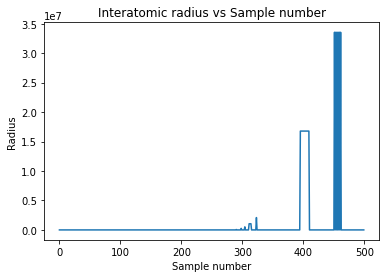

In [86]:
from matplotlib import pyplot as plt
r = [get_radius_pbc_scalar(a[0],a[1],50) for a in x]
plt.plot(range(len(r)),r)
plt.title('Interatomic radius vs Sample number')
plt.xlabel('Sample number')
plt.ylabel('Radius')
plt.show()

In [29]:
def get_radius_pbc_scalar(atom_1, atom_2, L):
    r = np.subtract(atom_1, atom_2)
    r_nearest = [a - L*round(a/L) for a in r]
    return np.sqrt(np.square(r_nearest).sum())

In [53]:
x

[array([[1.05, 1.05, 1.05],
        [0.  , 0.  , 0.  ]]),
 array([[ 1.05011593e+00,  1.04978839e+00,  1.04973544e+00],
        [-7.41145589e-05, -1.15882859e-04,  2.43514006e-05]]),
 array([[ 1.05026708e+00,  1.04961214e+00,  1.04950634e+00],
        [-1.74670482e-04, -2.58312857e-04,  2.20839142e-05]]),
 array([[ 1.05048815e+00,  1.04950632e+00,  1.04934801e+00],
        [-3.27717430e-04, -4.53609808e-04, -3.33061112e-05]]),
 array([[ 1.05081358e+00,  1.04950594e+00,  1.04929587e+00],
        [-5.59109321e-04, -7.28075606e-04, -1.68426535e-04]]),
 array([[ 1.05127742e+00,  1.04964591e+00,  1.04938539e+00],
        [-8.94410840e-04, -1.10789722e-03, -4.09890970e-04]]),
 array([[ 1.05191317e+00,  1.04996076e+00,  1.04965183e+00],
        [-1.35876954e-03, -1.61901243e-03, -7.84181051e-04]]),
 array([[ 1.05275356,  1.05048449,  1.05013007],
        [-0.00197676, -0.00228694, -0.00131747]]),
 array([[ 1.05383029,  1.05125027,  1.05085428],
        [-0.00277218, -0.00313658, -0.00203542]])